In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Initial setup for Kaggle
!pip install wandb -q
import wandb
wandb.login(key="559009604832a12ab57d01a86b6119ec05637a17")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eshan_kulkarni (eshan_kulkarni-indian-institute-of-technology-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
dataset_path = "/kaggle/input/inaturalist-12k/inaturalist_12K"  # Update this to your dataset path

In [3]:
# Check GPU availability in Kaggle
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Clear GPU cache (good practice in Kaggle)
torch.cuda.empty_cache()

Using GPU: Tesla T4


In [4]:
# Import libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import wandb
from PIL import Image

## Data Loading and Preparation with Stratified Split

In [6]:
# %% [markdown]
# ## Data Loading and Preparation with Stratified Split

# %%
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Define transforms (same as before)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'train'), transform=train_transform)

# Get class labels for stratified split
targets = np.array([label for _, label in full_dataset])

# Create stratified train-val split (80-20)
train_idx, val_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Create subset datasets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# Load test dataset
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, 'val'), transform=test_transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Verify class distribution in validation set
val_labels = [label for _, label in val_dataset]
unique, counts = np.unique(val_labels, return_counts=True)
print("Validation set class distribution:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples ({count/len(val_dataset):.1%})")

# Verify the splits are stratified
print(f"\nTotal samples: {len(full_dataset)}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")

Validation set class distribution:
Class 0: 200 samples (10.0%)
Class 1: 200 samples (10.0%)
Class 2: 200 samples (10.0%)
Class 3: 200 samples (10.0%)
Class 4: 200 samples (10.0%)
Class 5: 200 samples (10.0%)
Class 6: 200 samples (10.0%)
Class 7: 200 samples (10.0%)
Class 8: 200 samples (10.0%)
Class 9: 200 samples (10.0%)

Total samples: 9999
Train samples: 7999
Validation samples: 2000
Test samples: 2000
Number of classes: 10


## Part A: Training from Scratch

In [7]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, activation='relu', 
                 filters=[32, 64, 128, 256, 512], kernel_size=3, 
                 dense_neurons=512, dropout_rate=0.3, batch_norm=True):
        super(CustomCNN, self).__init__()
        
        # Select activation function
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'silu':
            self.activation = nn.SiLU()
        elif activation.lower() == 'mish':
            self.activation = nn.Mish()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        # Convolutional layers
        self.conv_layers = nn.ModuleList()
        in_channels = 3  # RGB images
        
        for i, out_channels in enumerate(filters):
            self.conv_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
            )
            if batch_norm:
                self.conv_layers.append(nn.BatchNorm2d(out_channels))
            self.conv_layers.append(self.activation)
            self.conv_layers.append(nn.MaxPool2d(2, 2))
            if dropout_rate > 0 and i < len(filters) - 1:  # No dropout before last conv layer
                self.conv_layers.append(nn.Dropout2d(dropout_rate))
            in_channels = out_channels
        
        # Calculate the size after convolutions and pooling
        self.flatten_size = self._get_conv_output_size((3, 128, 128))
        
        # Dense layers
        self.dense_layers = nn.Sequential(
            nn.Linear(self.flatten_size, dense_neurons),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(dense_neurons, num_classes)
        )
    
    def _get_conv_output_size(self, input_size):
        with torch.no_grad():
            x = torch.zeros(1, *input_size)
            for layer in self.conv_layers:
                x = layer(x)
            return int(torch.prod(torch.tensor(x.size()[1:])))
    
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dense_layers(x)
        return x
    
    def calculate_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def calculate_operations(self, input_size=(3, 128, 128)):
        total_flops = 0
        x = torch.zeros(1, *input_size)
        
        for layer in self.conv_layers:
            if isinstance(layer, nn.Conv2d):
                _, _, h, w = x.shape
                flops = (2 * layer.in_channels * layer.kernel_size[0]**2 - 1) * h * w * layer.out_channels
                total_flops += flops
            x = layer(x)
        
        x = x.view(x.size(0), -1)
        for layer in self.dense_layers:
            if isinstance(layer, nn.Linear):
                flops = (2 * layer.in_features - 1) * layer.out_features
                total_flops += flops
        
        return total_flops

In [8]:
# Example calculation for default parameters
model = CustomCNN()
print(f"Total parameters: {model.calculate_parameters()}")
print(f"Total FLOPs: {model.calculate_operations()}")

Total parameters: 14421258
Total FLOPs: 1958981110


### Hyperparameter Tuning with WandB Sweep

In [9]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
        
        model = CustomCNN(
            num_classes=10,
            activation=config.activation,
            filters=config.filters,
            kernel_size=config.kernel_size,
            dense_neurons=config.dense_neurons,
            dropout_rate=config.dropout_rate,
            batch_norm=config.batch_norm
        ).to(device)
        
        if config.optimizer == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        else:
            optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9)
        
        criterion = nn.CrossEntropyLoss()
        
        best_val_accuracy = 0
        early_stopping_counter = 0
        max_early_stopping = 5
        
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
            train_accuracy = 100. * correct / total
            train_loss = train_loss / len(train_loader)
            
            val_loss, val_accuracy = evaluate(model, val_loader, criterion)
            
            wandb.log({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy
            })
            
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stopping_counter = 0
                torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= max_early_stopping:
                    break

def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

In [10]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'   
    },
    'parameters': {
        'activation': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'filters': {
            'values': [
                [32, 32, 32, 32, 32],
                [32, 64, 128, 256, 512],
                [512, 256, 128, 64, 32],
                [64, 128, 256, 512, 1024],
            ]
        },
        'kernel_size': {
            'values': [3, 5]
        },
        'dense_neurons': {
            'values': [256, 512, 1024]
        },
        'dropout_rate': {
            'values': [0.0, 0.2, 0.3, 0.5]
        },
        'batch_norm': {
            'values': [True, False]
        },
        'batch_size': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-5,
            'max': 1e-2
        },
        'optimizer': {
            'values': ['adam']
        },
        'epochs':{'values':[10]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DA6401-PartA")
wandb.agent(sweep_id, train, count=10)

Create sweep with ID: pk1422to
Sweep URL: https://wandb.ai/eshan_kulkarni-indian-institute-of-technology-madras/DA6401-PartA/sweeps/pk1422to


wandb: Agent Starting Run: g9islat4 with config:
wandb: 	activation: mish
wandb: 	batch_norm: True
wandb: 	batch_size: 32
wandb: 	dense_neurons: 1024
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	filters: [32, 32, 32, 32, 32]
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.002996024887089703
wandb: 	optimizer: adam


wandb: Ctrl + C detected. Stopping sweep.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1243, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 114, in get
    raise Empty
_queue.Empty

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "<ipython-input-9-91807dbd0a54>", line 35, in train
    for inputs, labels in train_loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1448, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1412, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.10/dist-pa

epoch,▁█
train_accuracy,▁█
train_loss,█▁
val_accuracy,█▁
val_loss,▁█
epoch,1
train_accuracy,13.30166
train_loss,2.31351
val_accuracy,13.65
val_loss,2.25174


### Test Evaluation and Visualization

In [10]:
best_config = {
    'activation': 'silu',
    'filters': [64, 128,256,512,1024],
    'kernel_size': 3,
    'dense_neurons': 1024,
    'dropout_rate': 0,
    'batch_norm': True,
    'batch_size': 32,
    'learning_rate': 0.00002035,
    'optimizer': 'adam'
}

best_model = CustomCNN(
    num_classes=10,
    activation=best_config['activation'],
    filters=best_config['filters'],
    kernel_size=best_config['kernel_size'],
    dense_neurons=best_config['dense_neurons'],
    dropout_rate=best_config['dropout_rate'],
    batch_norm=best_config['batch_norm']
).to(device)

best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))

# Evaluate on test set
test_loss, test_accuracy = evaluate(best_model, test_loader, nn.CrossEntropyLoss())
print(f"Test Accuracy: {test_accuracy:.2f}%")

<ipython-input-10-93814c355750>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


Test Accuracy: 41.60%


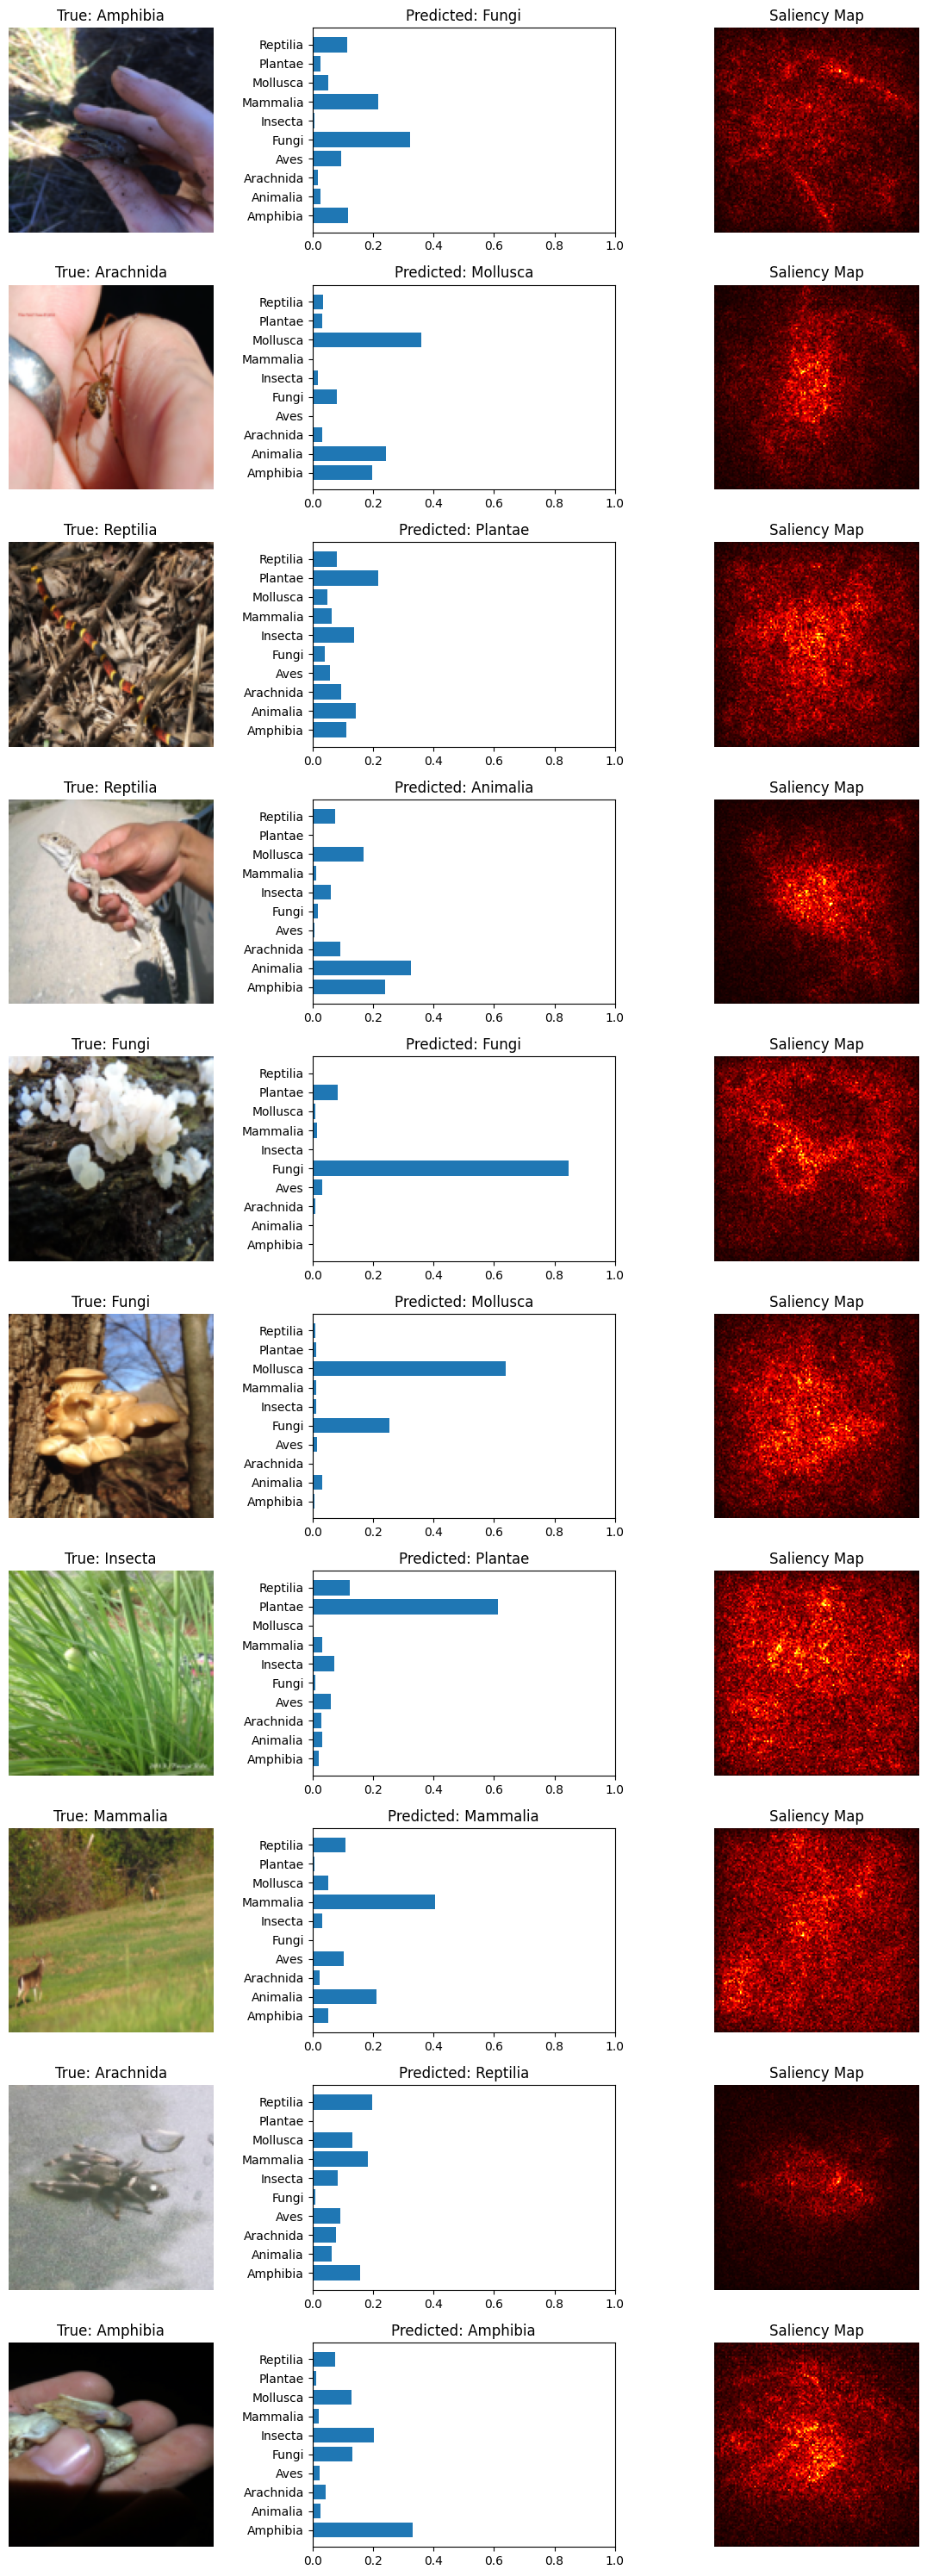

In [11]:
def visualize_predictions(model, loader, num_samples=10):
    model.eval()
    classes = full_dataset.classes
    
    indices = random.sample(range(len(loader.dataset)), num_samples)
    samples = [loader.dataset[i] for i in indices]
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3*num_samples))
    
    for i, (image, true_label) in enumerate(samples):
        img = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"True: {classes[true_label]}")
        axes[i, 0].axis('off')
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = output.max(1)
            predicted_label = predicted.item()
            probabilities = torch.softmax(output, dim=1)[0]
        
        axes[i, 1].barh(classes, probabilities.cpu().numpy())
        axes[i, 1].set_title(f"Predicted: {classes[predicted_label]}")
        axes[i, 1].set_xlim(0, 1)
        
        image.requires_grad_()
        output = model(image.unsqueeze(0).to(device))
        output[:, predicted_label].backward()
        saliency = image.grad.abs().max(dim=0)[0].cpu().numpy()
        
        axes[i, 2].imshow(saliency, cmap='hot')
        axes[i, 2].set_title("Saliency Map")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/test_predictions.png')
    plt.show()

visualize_predictions(best_model, test_loader)

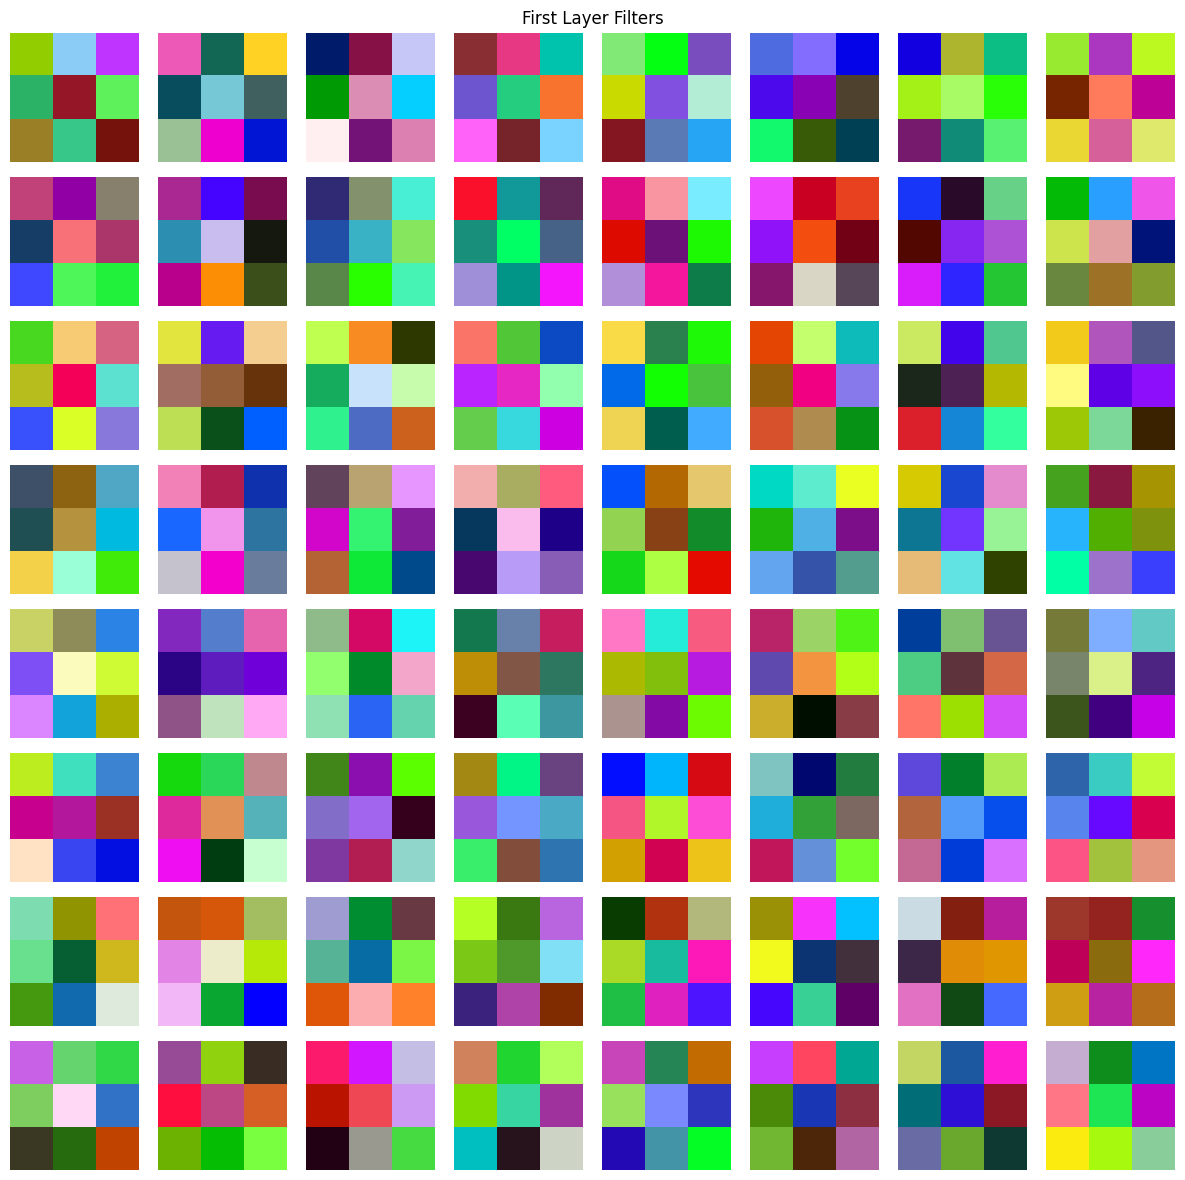

In [12]:
# Filter visualization
def visualize_filters(model):
    first_conv = model.conv_layers[0]
    if not isinstance(first_conv, nn.Conv2d):
        print("First layer is not a Conv2d layer")
        return
    
    filters = first_conv.weight.data.cpu().numpy()
    num_filters = filters.shape[0]
    sqrt_filters = int(np.ceil(np.sqrt(num_filters)))
    
    plt.figure(figsize=(12, 12))
    for i in range(num_filters):
        plt.subplot(sqrt_filters, sqrt_filters, i+1)
        f = filters[i]
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min)
        plt.imshow(f.transpose(1, 2, 0))
        plt.axis('off')
    
    plt.suptitle("First Layer Filters")
    plt.tight_layout()
    plt.savefig('/kaggle/working/first_layer_filters.png')
    plt.show()

visualize_filters(best_model)

## Part B: Fine-tuning a Pre-trained Model

In [11]:
def create_pretrained_model(model_name='resnet50', num_classes=10, freeze_layers=True):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    elif model_name == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    
    if hasattr(model, 'fc'):
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unsupported model architecture")
    
    return model.to(device)

In [12]:
# Fine-tuning strategies
model_strategy1 = create_pretrained_model('resnet50', freeze_layers=True)
model_strategy2 = create_pretrained_model('resnet50', freeze_layers=False)
for name, param in model_strategy2.named_parameters():
    if 'layer1' in name or 'layer2' in name or 'conv1' in name:
        param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


In [13]:
# Fine-tuning function
def fine_tune_model(model, model_name, train_loader, val_loader, num_epochs=20, lr=0.001):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_accuracy = 0
    wandb.init(project="DA6401-PartB", name=f"finetune-{model_name}")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_accuracy = 100. * correct / total
        train_loss = train_loss / len(train_loader)
        
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'/kaggle/working/best_{model_name}_model.pth')
    
    wandb.finish()
    return model

In [14]:
# Fine-tune using strategy 1
model_ft = create_pretrained_model('resnet50')
fine_tune_model(model_ft, 'resnet50_frozen', train_loader, val_loader)

# Evaluate fine-tuned model
model_ft.load_state_dict(torch.load('/kaggle/working/best_resnet50_frozen_model.pth'))
test_loss, test_accuracy = evaluate(model_ft, test_loader, nn.CrossEntropyLoss())
print(f"Fine-tuned Test Accuracy: {test_accuracy:.2f}%")

wandb: WARNING Ignoring project 'DA6401-PartB' when running a sweep.


KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


## Save All Outputs

In [ ]:
# Save all important files
import shutil

# Create a directory for outputs
os.makedirs('/kaggle/working/outputs', exist_ok=True)

# Save model weights
shutil.copy('/kaggle/working/best_model.pth', '/kaggle/working/outputs/')
shutil.copy('/kaggle/working/best_resnet50_frozen_model.pth', '/kaggle/working/outputs/')

# Save visualizations
shutil.copy('/kaggle/working/test_predictions.png', '/kaggle/working/outputs/')
shutil.copy('/kaggle/working/first_layer_filters.png', '/kaggle/working/outputs/')

print("All outputs saved to /kaggle/working/outputs")